# Transfer Learning: Skin Cancer Detection
<hr style="border:2px solid black">

### Load packages

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# miscellaneous
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# deep learning stack
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder

**Load data**

In [2]:
train = pd.read_csv("Augmentation/train_df.csv")
test = pd.read_csv("Augmentation/test_df.csv")

In [3]:
train.shape, test.shape

((600, 59), (60, 59))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          600 non-null    int64  
 1   background_father_BRAZIL       600 non-null    int64  
 2   background_father_GERMANY      600 non-null    int64  
 3   background_father_ITALY        600 non-null    int64  
 4   background_father_NETHERLANDS  600 non-null    int64  
 5   background_father_POLAND       600 non-null    int64  
 6   background_father_POMERANIA    600 non-null    int64  
 7   background_father_PORTUGAL     600 non-null    int64  
 8   background_father_SPAIN        600 non-null    int64  
 9   background_father_UNK          600 non-null    int64  
 10  background_mother_FRANCE       600 non-null    int64  
 11  background_mother_GERMANY      600 non-null    int64  
 12  background_mother_ITALY        600 non-null    int

In [5]:
CLASSES = sorted(train['diagnostic'].unique())

In [6]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(
    train['diagnostic'].values.reshape(-1, 1)
)
y_train = np.array(y_train.todense())

## Pre-trained Model

### 2.2 Load model

[`mobilenet_v2`](https://keras.io/api/applications/mobilenet/)

In [7]:
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2,
    preprocess_input,
    decode_predictions
)

[`resnet50`](https://keras.io/api/applications/resnet/#resnet50-function)

In [8]:
# # resnet50
# from tensorflow.keras.applications.resnet50 import (
#     ResNet50,
#     preprocess_input,
#     decode_predictions
# )

### 2.3 User-defined functions

In [9]:
def load_image(image_path):
    """
    loads an input image into PIL format of size 224 X 224
    """
    img = image.load_img(
        path=image_path,
        target_size=(224,224)
    )
    return img

In [10]:
def batch_image(loaded_image):
    """
    converts a loaded image to a batch
    """
    img_array = image.img_to_array(loaded_image)
    img_batch = np.array([img_array])
    
    return img_batch

In [11]:
def preprocess_image(batched_image):
    """
    preprocesses a batch image to make suitable for mobilenet_v2
    """
    processed_img = preprocess_input(batched_image)
    
    return processed_img

In [12]:
def show_preprocess_image(image_path):
    """
    shows loaded image given an image path, and
    preprocesses it to make suitable for mobilenet_v2
    """
    # load resized image
    loaded_img = load_image(image_path)
    
    # display image
    plt.figure(figsize=(3,3), dpi=100)
    plt.imshow(loaded_img)
    
    # create batched image
    batch_img = batch_image(loaded_img)
    
    # preprocess image
    processed_img = preprocess_image(batch_img)
    
    return processed_img

In [13]:
def image_class_prediction(model, preprocessed_image):
    """
    spits out the top-5 predictions of a given model with a proprocessed image
    """
    model_prediction = model.predict(preprocessed_image,verbose=0)
    decoded_prediction = decode_predictions(model_prediction,top=5)[0]
    data = {
        'image_class': [_[1] for _ in decoded_prediction],
        'probability': [_[2] for _ in decoded_prediction]
    }
    df = pd.DataFrame(data=data)
    return df

### Model evaluation

**image classes**

In [14]:
CLASSES

['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

<hr style="border:2px solid black">

## Transfer Learning

[**getting training images into keras**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [15]:
# instantiate image data generator

data_gen = image.ImageDataGenerator(
    # preprocessing function for all images
    preprocessing_function=preprocess_input
)

In [16]:
train_generator = data_gen.flow_from_dataframe(
    dataframe=train,
    directory="./cancer/images/train",
    x_col="img_id",
    y_col="diagnostic",
    target_size=(224,224),
    batch_size=600,
    class_mode="categorical",
    shuffle=False
)

Found 600 validated image filenames belonging to 6 classes.


In [17]:
# load in all images at once

x_train = next(train_generator)[0]
x_train.shape

(600, 224, 224, 3)

### 3.1 Model Building 

**3.1.1 Select convolutional base with frozen weights**

In [18]:
# define base model

BASE_MODEL = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,          # controls number of overall weights
    include_top=False,  # removal of final dense layers
    pooling='avg',      # average pooling to last convolutional layer's ouput
    input_shape=(224,224,3) # ignored if input tensor is provided
)

In [19]:
# BASE_MODEL = ResNet50(
#     weights='imagenet', 
#     include_top=False,  # removal of final dense layers
#     pooling='avg',      # average pooling to last convolutional layer's ouput
#     input_shape=(224,224,3) # ignored if input tensor is provided
# )

In [20]:
# freeze base model
BASE_MODEL.trainable = False

In [21]:
# base model summary
BASE_MODEL.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**3.1.2 Add dense layers on top**

In [22]:
def build_ann():
    '''
    complies a model by stacking dense layers on top of base model 
    '''
    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(BASE_MODEL)
    
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=16, 
            activation='sigmoid'
        )
    )
    # dropout 
    model.add(
        keras.layers.Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    return model

In [23]:
def compile_ann(ann):
    """
    """
    ann.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )
    return ann

### 3.3 Model Training

**train model**

In [24]:
# instantiate model
model = build_ann()
model = compile_ann(model)

In [25]:
# early stopping

stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10
)

In [27]:
model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=50,
    callbacks=[stop_early],
    validation_split=1/6
)

Epoch 1/100
10/10 [==============================] - 10s 976ms/step - loss: 1.5767 - categorical_accuracy: 0.3420 - val_loss: 1.5340 - val_categorical_accuracy: 0.4200
Epoch 2/100
10/10 [==============================] - 9s 961ms/step - loss: 1.5219 - categorical_accuracy: 0.3440 - val_loss: 1.4664 - val_categorical_accuracy: 0.4700
Epoch 3/100
10/10 [==============================] - 9s 938ms/step - loss: 1.4740 - categorical_accuracy: 0.3720 - val_loss: 1.4473 - val_categorical_accuracy: 0.5200
Epoch 4/100
10/10 [==============================] - 9s 959ms/step - loss: 1.4205 - categorical_accuracy: 0.4380 - val_loss: 1.4395 - val_categorical_accuracy: 0.5100
Epoch 5/100
10/10 [==============================] - 9s 939ms/step - loss: 1.4148 - categorical_accuracy: 0.4140 - val_loss: 1.4112 - val_categorical_accuracy: 0.5100
Epoch 6/100
10/10 [==============================] - 9s 954ms/step - loss: 1.3902 - categorical_accuracy: 0.4320 - val_loss: 1.4014 - val_categorical_accuracy: 0.54

**training history: losses and epoch numbers**

In [27]:
# losses in the training history
losses = pd.DataFrame(model.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

**plot training history**

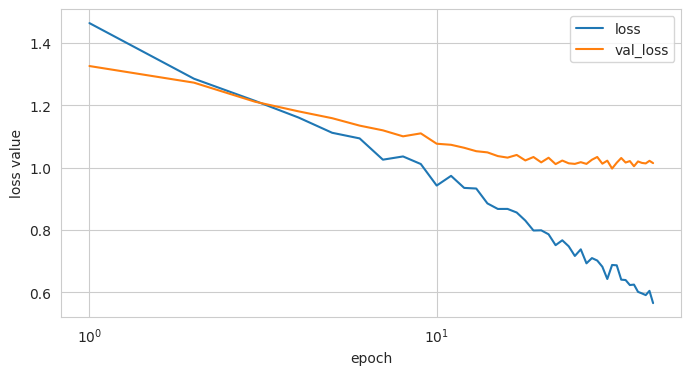

In [28]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,4),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=10)
plt.ylabel('loss value',fontsize=10)
plt.legend(loc=1,fontsize=10);

### Model Evaluation

In [29]:
test_generator = data_gen.flow_from_dataframe(
    dataframe=test,
    directory="./images/test",
    x_col="img_id",
    y_col="diagnostic",
    target_size=(224,224),
    batch_size=600,
    class_mode="categorical",
    shuffle=False
)

Found 40 validated image filenames belonging to 4 classes.


In [30]:
# load in all images at once

x_test = next(test_generator)[0]
x_test.shape

(40, 224, 224, 3)

In [31]:
y_test = ohe.transform(
    test['diagnostic'].values.reshape(-1, 1)
)
y_test = np.array(y_test.todense())

In [32]:
y_test.shape

(40, 4)

In [33]:
def hard_prediction(model, X, y):
    """
    returns dataframe with class probabilities 
    and true class label 
    """
    # prediction dataframe along with true class
    pred = model.predict(X,verbose=0)
    pred = np.array(
        [pred[i]==pred[i].max() for i in range(len(pred))]
    ).astype(int)
    
    df_pred = pd.DataFrame(
        columns=CLASSES,
        data=pred
    )
    # convert vectorized classes into strings
    df_pred['class'] = \
    [''.join([i*j for (i,j) in zip(CLASSES,vector)]) for vector in y.astype(int)]
    
    return df_pred

In [35]:
hard_prediction(model, x_test, y_test)

,ACK,BCC,MEL,SCC,class
0,0,1,0,0,ACK
1,0,0,0,1,BCC
2,0,0,1,0,MEL
3,0,0,1,0,MEL
4,0,0,0,1,BCC
5,0,1,0,0,BCC
6,0,1,0,0,BCC
7,1,0,0,0,BCC
8,1,0,0,0,ACK
9,0,0,1,0,MEL


In [40]:
def accuracy_score(model,X,y):
    """
    This function spits out multi-class accuracy
    """
    grouped_df = hard_prediction(model, X, y).groupby('class').sum()
    
    grouped_df.sort_index(axis=1,inplace=True)
    
    accuracy_score = np.trace(grouped_df)/np.array(grouped_df).sum()
    accuracy_score = round(accuracy_score,6)
    
    return accuracy_score

In [44]:
accuracy_score(model, x_train, y_train)

0.88

In [42]:
accuracy_score(model, x_test, y_test)

0.5